# Piecewise mollification

$Blah\ blah\ $

In [33]:
from scipy.optimize import curve_fit
from __future__ import print_function

import os, sys
import numpy as np
import scipy as sp
from numpy import sin, cos, exp, log, log10, pi, absolute, power, sqrt
from numpy.polynomial import chebyshev as T
from numpy.polynomial import hermite_e as H
from scipy.integrate import quad
from scipy.misc import factorial
from scipy.stats import linregress
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from spectral_tools import Decompose, ModalD, NodalD, Vandermonde
from edgedetect import ChebEdgeIII, ConfigurePlots, Enhance, LocateEdges, MinMod

In [2]:
N = 32
x = np.linspace(-1.0, 1.0, 2001)
c2s, s2c = Vandermonde(N)
modalD = ModalD(c2s)

In [3]:
step_loc1 = -0.4
width1 = 1.0
chi1 = lambda x: 1.0 if (x>=step_loc1 and x<=(step_loc1+width1)) else 0
a_n1 = Decompose(chi1, c2s)
I_N1 = T.chebval(x, a_n1)
c_j1 = LocateEdges(a_n1, x, modalD)
chi1_x = np.frompyfunc(chi1, 1, 1)(x)

step_loc2 = 0.5
width2 = 1.0
chi2 = lambda x: 1.0 if (x>=step_loc2 and x<=(step_loc2+width2)) else 0
a_n2 = Decompose(chi2, c2s)
I_N2 = T.chebval(x, a_n2)
c_j2 = LocateEdges(a_n2, x, modalD)
chi2_x = np.frompyfunc(chi2, 1, 1)(x)

In [4]:
ConfigurePlots()

In [5]:
def MollifyQuad(theta, c_j, a_n, x):
    
    N = a_n.shape[0]-1
    sanity_check = np.empty(len(x))
    mollified = np.array([])
    mollified_err = np.array([])
    
    I_N = lambda y: T.chebval(y, a_n)
    chi_top = lambda y,f : f(y) if -1 <= y <= 1 else 0
    I_N_top = lambda y: chi_top(y, I_N)
    c_jplus = np.append(c_j, 1.0)
    
    for idx_c, pos in enumerate(c_jplus):
        
        if idx_c == 0:
            
            lim_left = -1.0
            lim_right = pos
            
            offset = np.ma.masked_where(x > lim_right, x)
            offset = np.ma.compressed(offset)

        else:
            
            lim_left = c_jplus[idx_c-1]
            lim_right = pos
            
            offset = np.ma.masked_where(x > lim_right, x)
            offset = np.ma.masked_where(x <= lim_left, offset)
            offset = np.ma.compressed(offset)

        chi_cut = lambda y,f : f(y) if lim_left <= y <= lim_right else 0
        convolution = np.empty(len(offset))
        convolution_err = np.empty(len(offset))

        for idx_o, off_x in enumerate(offset):
            c_jx = c_j - off_x
            dx = lambda y: sqrt(theta*N*min(abs(y-c) for c in c_jx))
            var = lambda y: N/(2*theta*dx(y))
            p_N = lambda y: (theta**2)*dx(y)*N
            j_max = int(np.amax(np.frompyfunc(p_N,1,1)(x)))
            h_j = np.zeros(2*(j_max+1))
    
            for j in range(j_max+1):
                h_j[2*j] = ((-1)**j)/((4**j)*factorial(j))
    
            hermite = lambda y: H.hermeval(sqrt(var(y))*y, h_j)
            expon = lambda y: (1./sqrt(theta*N*dx(y)))*exp(-var(y)*(y**2))
            phi0 = lambda y: hermite(y)*expon(y)
            phi_off = lambda y: phi0(y-off_x)
            phi = lambda y: chi_cut(y, phi_off)
            norm = quad(phi, lim_left, lim_right)[0]
        
            convfunc = lambda y: (1/norm)*(phi(y) * I_N_top(y))
            convolution[idx_o], convolution_err[idx_o] = quad(convfunc, lim_left, lim_right)
            
        mollified = np.append(mollified, convolution)
        mollified_err = np.append(mollified_err, convolution_err)
        
    assert mollified.shape == sanity_check.shape, "Piecewise mollification inconsistent with regular one"
    assert mollified_err.shape == sanity_check.shape, "Piecewise mollification inconsistent with regular one"

    return mollified, mollified_err


# N=32 piecewise mollification

In [7]:
theta = 1./4.
mollified1_32, mollified1_err_32 = MollifyQuad(theta, c_j1, a_n1, x)
mollified2_32, mollified1_err_32 = MollifyQuad(theta, c_j2, a_n2, x)
error1_32 = absolute(mollified1_32 - chi1_x)
error2_32 = absolute(mollified2_32 - chi2_x)

(<matplotlib.legend.Legend at 0x11367f6d0>,
 <matplotlib.legend.Legend at 0x1136a9450>)

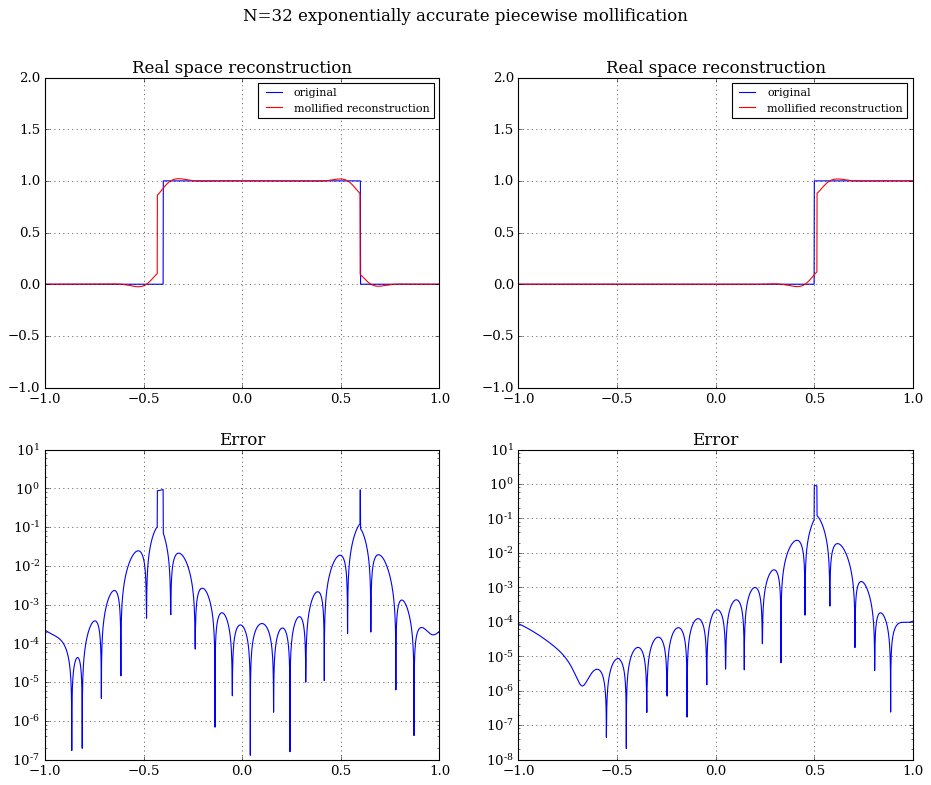

In [8]:
fig, axarr = plt.subplots(2,2, figsize=(14,11))
plt.suptitle('N=32 exponentially accurate piecewise mollification', fontsize=15)
axarr[0,0].plot(x, chi1_x, label='original')
axarr[0,0].plot(x, mollified1_32, 'r',  label='mollified reconstruction')
axarr[0,1].plot(x, chi2_x, label='original')
axarr[0,1].plot(x, mollified2_32, 'r', label='mollified reconstruction')
axarr[1,0].semilogy(x, error1_32)
axarr[1,1].semilogy(x, error2_32)
axarr[0,0].set_title('Real space reconstruction')
axarr[0,1].set_title('Real space reconstruction')
axarr[1,0].set_title('Error')
axarr[1,1].set_title('Error')
axarr[0,0].legend(), axarr[0,1].legend()

# N=64 piecewise mollification

In [9]:
N = 64
x = np.linspace(-1.0, 1.0, 2001)
c2s64, s2c64 = Vandermonde(N)
modalD64 = ModalD(c2s64)

step_loc1 = -0.4
width1 = 1.0
chi1 = lambda x: 1.0 if (x>=step_loc1 and x<=(step_loc1+width1)) else 0
a_n164 = Decompose(chi1, c2s64)
I_N164 = T.chebval(x, a_n164)
c_j164 = LocateEdges(a_n164, x, modalD64)
chi1_x64 = np.frompyfunc(chi1, 1, 1)(x)

step_loc2 = 0.5
width2 = 1.0
chi2 = lambda x: 1.0 if (x>=step_loc2 and x<=(step_loc2+width2)) else 0
a_n264 = Decompose(chi2, c2s64)
I_N264 = T.chebval(x, a_n264)
c_j264 = LocateEdges(a_n264, x, modalD64)
chi2_x64 = np.frompyfunc(chi2, 1, 1)(x)

In [10]:
mollified1_64, mollified1_err_64 = MollifyQuad(theta, c_j164, a_n164, x)
mollified2_64, mollified1_err_64 = MollifyQuad(theta, c_j264, a_n264, x)
error1_64 = absolute(mollified1_64 - chi1_x)
error2_64 = absolute(mollified2_64 - chi2_x)

/Users/asiamacbook/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


(<matplotlib.legend.Legend at 0x11567ea50>,
 <matplotlib.legend.Legend at 0x1156a47d0>)

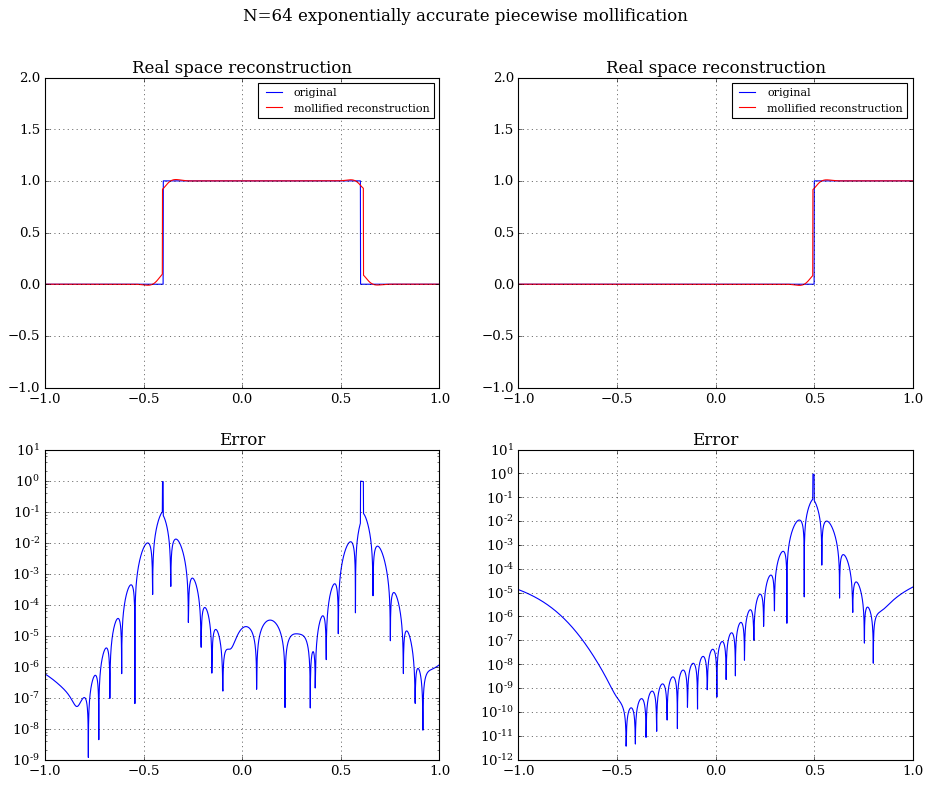

In [11]:
fig, axarr = plt.subplots(2,2, figsize=(14,11))
plt.suptitle('N=64 exponentially accurate piecewise mollification', fontsize=15)
axarr[0,0].plot(x, chi1_x, label='original')
axarr[0,0].plot(x, mollified1_64, 'r',  label='mollified reconstruction')
axarr[0,1].plot(x, chi2_x, label='original')
axarr[0,1].plot(x, mollified2_64, 'r', label='mollified reconstruction')
axarr[1,0].semilogy(x, error1_64)
axarr[1,1].semilogy(x, error2_64)
axarr[0,0].set_title('Real space reconstruction')
axarr[0,1].set_title('Real space reconstruction')
axarr[1,0].set_title('Error')
axarr[1,1].set_title('Error')
axarr[0,0].legend(), axarr[0,1].legend()

# N - dependence

In [12]:
N_val = np.logspace(4, 7, num=4, endpoint=True, base=2)
err_N2 = np.empty((2*len(N_val), len(x)))
repr_N2 = np.empty((2*len(N_val), len(x)))

for idx, N in enumerate(N_val):
    c2s_n, s2c_n = Vandermonde(int(N))
    modalD_n = ModalD(c2s_n)
    a_n1_n = Decompose(chi1, c2s_n)
    I_N1_n = T.chebval(x, a_n1_n)
    c_j1_n = LocateEdges(a_n1_n, x, modalD_n)
    
    a_n2_n = Decompose(chi2, c2s_n)
    I_N2_n = T.chebval(x, a_n2_n)
    c_j2_n = LocateEdges(a_n2_n, x, modalD_n)
    
    repr_N2[2*idx,:], mollify_err1 = MollifyQuad(theta, c_j1_n, a_n1_n, x)
    repr_N2[(2*idx)+1,:], mollify_err2 = MollifyQuad(theta, c_j2_n, a_n2_n, x)
    
    err_N2[2*idx,:] = absolute(repr_N2[2*idx,:] - chi1_x)
    err_N2[(2*idx)+1,:] = absolute(repr_N2[(2*idx)+1,:] - chi2_x)

(<matplotlib.legend.Legend at 0x1165b51d0>,
 <matplotlib.legend.Legend at 0x11573e950>)

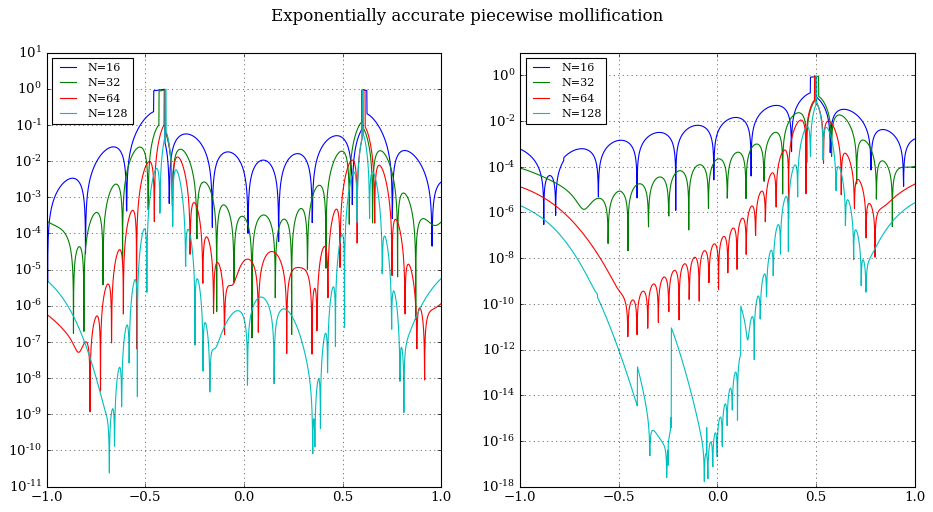

In [13]:
fig, axarr = plt.subplots(1,2, figsize=(14,7))
plt.suptitle('Exponentially accurate piecewise mollification', fontsize=15)
axarr[0].semilogy(x, err_N2[0,:], label='N=16'), axarr[1].semilogy(x, err_N2[1,:], label='N=16')
axarr[0].semilogy(x, err_N2[2,:], label='N=32'), axarr[1].semilogy(x, err_N2[3,:], label='N=32')
axarr[0].semilogy(x, err_N2[4,:], label='N=64'), axarr[1].semilogy(x, err_N2[5,:], label='N=64')
axarr[0].semilogy(x, err_N2[6,:], label='N=128'), axarr[1].semilogy(x, err_N2[7,:], label='N=128')
axarr[0].legend(loc='upper left'), axarr[1].legend(loc='upper left')

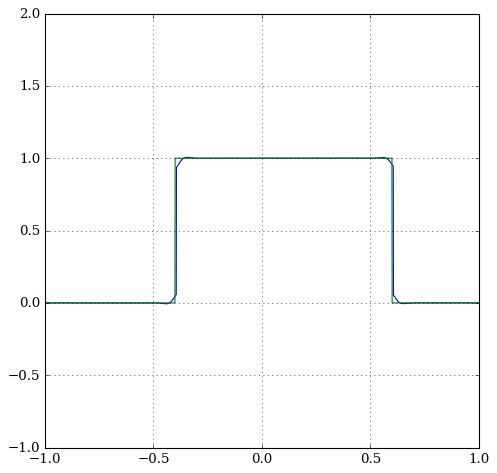

In [16]:
plt.plot(x, repr_N2[-2,:])
plt.plot(x, chi1_x)

# Theta-dependence for N=64

In [18]:
theta_val = np.array([0.1, 0.25, 0.5, 0.7])
repr_theta = np.empty((2*len(theta_val), len(x)))
err_theta = np.empty((2*len(theta_val), len(x)))

for idx, theta in enumerate(theta_val):
    
    repr_theta[2*idx,:], mollify_err1 = MollifyQuad(theta, c_j164, a_n164, x)
    repr_theta[(2*idx)+1,:], mollify_err2 = MollifyQuad(theta, c_j264, a_n264, x)
    
    err_theta[2*idx,:] = absolute(repr_theta[2*idx,:] - chi1_x)
    err_theta[(2*idx)+1,:] = absolute(repr_theta[(2*idx)+1,:] - chi2_x)
    

/Users/asiamacbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in multiply


(<matplotlib.legend.Legend at 0x117340e90>,
 <matplotlib.legend.Legend at 0x117895050>)

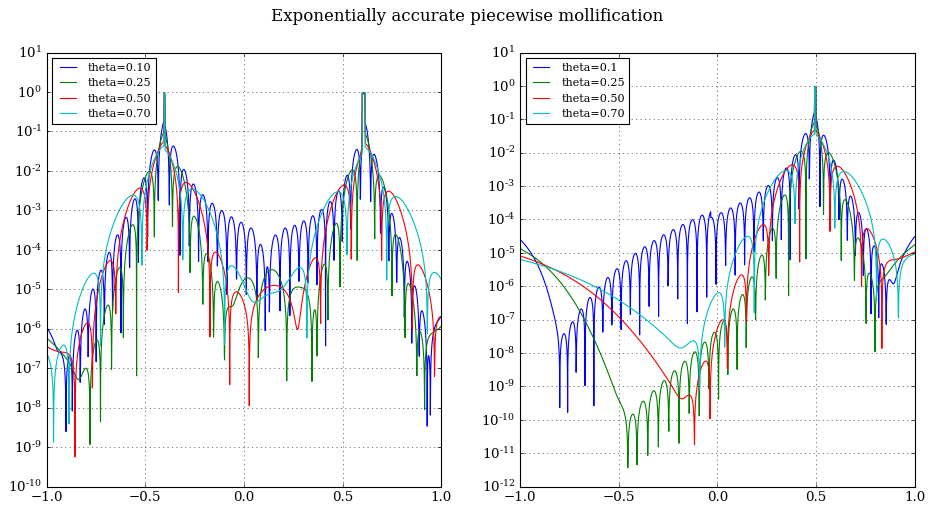

In [19]:
fig, axarr = plt.subplots(1,2, figsize=(14,7))
plt.suptitle('Exponentially accurate piecewise mollification', fontsize=15)
axarr[0].semilogy(x, err_theta[0,:], label='theta=0.10'), axarr[1].semilogy(x, err_theta[1,:], label='theta=0.1')
axarr[0].semilogy(x, err_theta[2,:], label='theta=0.25'), axarr[1].semilogy(x, err_theta[3,:], label='theta=0.25')
axarr[0].semilogy(x, err_theta[4,:], label='theta=0.50'), axarr[1].semilogy(x, err_theta[5,:], label='theta=0.50')
axarr[0].semilogy(x, err_theta[6,:], label='theta=0.70'), axarr[1].semilogy(x, err_theta[7,:], label='theta=0.70')
axarr[0].legend(loc='upper left'), axarr[1].legend(loc='upper left')

In [20]:
def ChoppedMollifiers(theta, c_j, a_n, x):
    
    fig, ax = plt.subplots(figsize=(14,6))
    plt.title('N=32 chopped mollifiers illustration')
    plt.xlim(-1.05,1.05)
    plt.ylim(0, 25)
    N = a_n.shape[0]-1
    x_set = np.linspace(-1.0, 1.0, 25)
    colors = np.array(['b', 'r', 'g', 'm'], dtype='str')

    
    I_N = lambda y: T.chebval(y, a_n)
    chi_top = lambda y,f : f(y) if -1 <= y <= 1 else 0
    I_N_top = lambda y: chi_top(y, I_N)
    c_jplus = np.append(c_j, 1.0)
    plt.axvline(x=-1.0, c='k', lw=1.2, ls='--', label='subdomain boundaries')
    plt.legend()
    
    for idx_c, pos in enumerate(c_jplus):
        
        plt.axvline(x=pos, c='k', lw=1.2, ls='--')
        
        if idx_c == 0:
            
            lim_left = -1.0
            lim_right = pos
            
            offset = np.ma.masked_where(x_set > lim_right, x_set)
            offset = np.ma.compressed(offset)

        else:
            
            lim_left = c_jplus[idx_c-1]
            lim_right = pos
            
            offset = np.ma.masked_where(x_set > lim_right, x_set)
            offset = np.ma.masked_where(x_set <= lim_left, offset)
            offset = np.ma.compressed(offset)
        
        col = colors[idx_c]

        chi_cut = lambda y,f : f(y) if lim_left <= y <= lim_right else 0

        for idx_o, off_x in enumerate(offset):
            c_jx = c_j - off_x
            dx = lambda y: sqrt(theta*N*min(abs(y-c) for c in c_jx))
            var = lambda y: N/(2*theta*dx(y))
            p_N = lambda y: (theta**2)*dx(y)*N
            j_max = int(np.amax(np.frompyfunc(p_N,1,1)(x)))
            h_j = np.zeros(2*(j_max+1))
    
            for j in range(j_max+1):
                h_j[2*j] = ((-1)**j)/((4**j)*factorial(j))
    
            hermite = lambda y: H.hermeval(sqrt(var(y))*y, h_j)
            expon = lambda y: (1./sqrt(theta*N*dx(y)))*exp(-var(y)*(y**2))
            phi0 = lambda y: hermite(y)*expon(y)
            phi_off = lambda y: phi0(y-off_x)
            phi = lambda y: chi_cut(y, phi_off)
            norm = quad(phi, lim_left, lim_right)[0]

            plt.plot(x, np.frompyfunc(phi, 1, 1)(x)/norm, c=col)


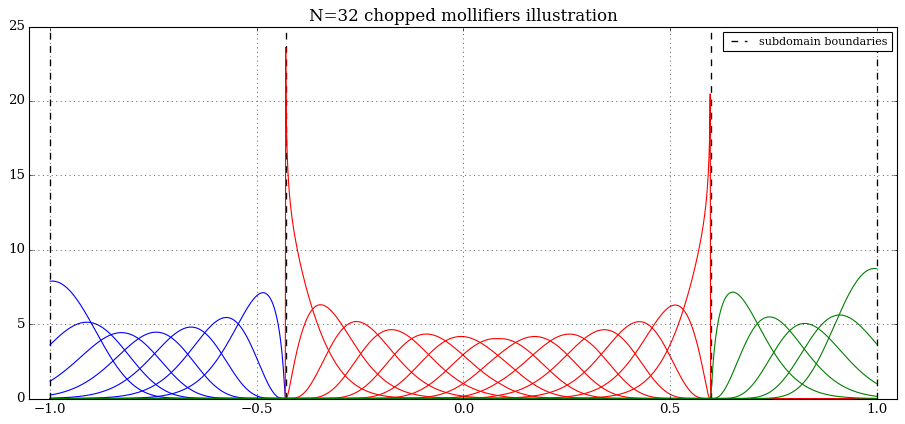

In [21]:
theta = 1./4.
ChoppedMollifiers(theta, c_j1, a_n1, x)

In [22]:
err_x0 = np.empty((len(N_val), 2))
for idx, N in enumerate(N_val):
    err_x0[idx, 0] = err_N2[2*idx, 1000]
    err_x0[idx, 1] = err_N2[2*idx + 1, 1000]

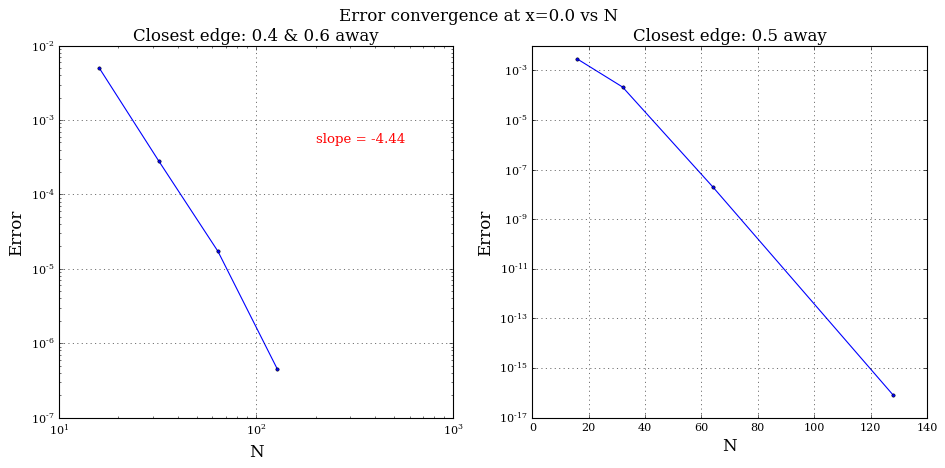

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
plt.suptitle('Error convergence at x=0.0 vs N', fontsize=15)
ax1.loglog(N_val, err_x0[:,0], 'o-')
ax2.semilogy(N_val, err_x0[:,1], 'o-')
ax1.set_xlabel('N'), ax1.set_ylabel('Error')
ax2.set_xlabel('N'), ax2.set_ylabel('Error')
ax1.set_title('Closest edge: 0.4 & 0.6 away')
ax2.set_title('Closest edge: 0.5 away')

logN = log(N_val)
logerr = log(err_x0[:,0])
slope, intercept, r_value, p_value, std_err = linregress(logN, logerr)
ax1.text(200, 0.0005, 'slope = %.2f' %slope, fontsize=12, color='r')

(<matplotlib.legend.Legend at 0x11d3b3f90>,
 <matplotlib.legend.Legend at 0x11d3f9390>)

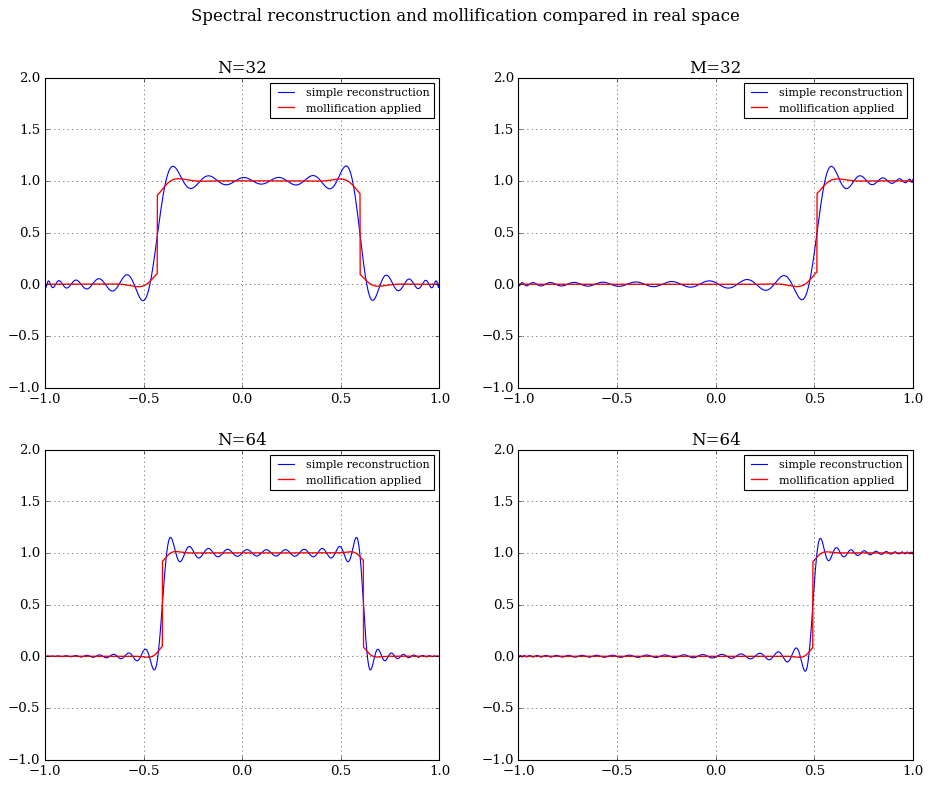

In [30]:
fig, axarr = plt.subplots(2,2, figsize=(14,11))
plt.suptitle('Spectral reconstruction and mollification compared in real space', fontsize=15)
axarr[0,0].plot(x, I_N1, label='simple reconstruction')
axarr[0,0].plot(x, mollified1_32, 'r', lw=1.2, label='mollification applied')
axarr[0,1].plot(x, I_N2, label='simple reconstruction')
axarr[0,1].plot(x, mollified2_32, 'r', lw=1.2, label='mollification applied')
axarr[1,0].plot(x, I_N164, label='simple reconstruction')
axarr[1,0].plot(x, mollified1_64, 'r', lw=1.2, label='mollification applied')
axarr[1,1].plot(x, I_N264, label='simple reconstruction')
axarr[1,1].plot(x, mollified2_64, 'r', lw=1.2, label='mollification applied')
axarr[0,0].set_title('N=32')
axarr[0,1].set_title('M=32')
axarr[1,0].set_title('N=64')
axarr[1,1].set_title('N=64')
axarr[0,0].legend(), axarr[0,1].legend(), axarr[1,0].legend(), axarr[1,1].legend()